# Project 1 — Berry–Esseen Rate for Fixed Degree _d_

Empirical confirmation that the overlap  
$$
X_N := \sqrt{N}\,\langle q, u_2\rangle
$$
between a fixed test vector $q\perp\mathbf 1$ and the second eigenvector $u_2$ of a **random $d$-regular graph** converges to 𝒩(0, 1) at the **optimal Berry–Esseen rate**
$$
\sup_x \bigl|\mathbb P(X_N\le x)-\Phi(x)\bigr| \;=\; \Theta\!\bigl(N^{-1/6}\bigr),
$$
as established in Nagel (2025) and Huang–Yau (2023).

**Credits**: This notebook was written by [Hershraj Niranjani](https://hershrajn.com)

---

## Experimental Design

| Stage | What we do | Key parameters |
|-------|------------|----------------|
| **Graph generation** | Build $M \approx 7,000$ simple $d$‑regular graphs for every $(N, d)$ using edge-swapping Monte Carlo. | $d \in \{3,5,8,10\};\; N \in \{1\,000, 10\,000, 50\,000\}$; Rust backend with `3 \times N \times d` edge swaps per graph. |
| **Storage format** | Save as compressed sparse CSR matrices (`.npz` files) for memory efficiency. | `scipy.sparse.save_npz` with compression; adjacency matrices stored as uint8. |
| **Spectral step** | Form the normalised adjacency $\tilde A = A / \sqrt{d-1}$ and extract $u_2$. | `scipy.sparse.linalg.eigsh` with `k=2`, `which="LA"`, `tol=1e-2` |
| **Statistic** | Compute $X_N$ with $q = e_1 - \dfrac{1}{N}\mathbf 1$ (normalised). | Any deterministic $q \perp \mathbf 1$ works. |
| **Distance metric** | Kolmogorov–Smirnov distance $D_N = \sup_x \lvert F_N(x) - \Phi(x) \rvert$. | Use SciPy's `stats.kstest` with `norm.cdf` reference. |
| **Rate extraction** | Linear regression of $\log D_N$ on $\log N$. | Slope $\approx -1/6$ corroborates theory. |


In [1]:
# Note: This was ran in a python virtual environment with python version 3.13.5
# Install the necessary dependencies
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import os 
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import re
import scipy.sparse.linalg as spla
import scipy.sparse as sp
from scipy.stats import kstest, norm, gaussian_kde
import pandas as pd
from typing import List, Sequence

RANDOM_SEED = 42 # 42 for reproducibility

BASE = Path(os.path.abspath(''))

FIGURES = BASE / "figures"
FIGURES.mkdir(exist_ok=True) # Ensure that the figures directory exists

DATA = BASE / "data"
DATA.mkdir(exist_ok=True) # Ensure that the data directory exists


NUM_GRAPHS_TO_LOAD = 1_00 # Number of graphs to load in per (n, d) configuration

print("Setup complete.")

/Users/hershraj.niranjani/Documents/GitHub/randomgraphs-universality-bounds/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete.


In [3]:
def load_graphs(file_names: Sequence[str], in_dir: str | Path) -> List[nx.Graph]:
    """Load .npz edge lists (saved by generate_graphs.py) into NetworkX graphs."""
    graphs: List[nx.Graph] = []
    for file_name in file_names:
        file_path = Path(in_dir) / file_name
        data = np.load(file_path)
        edges = data["edges"]          # shape (m, 2), dtype uint32
        g = nx.Graph()
        g.add_edges_from(map(tuple, edges))
        graphs.append(g)
    return graphs

## Run the analysis
Make sure that you have generated the graphs using the `generate_graphs.py` script

In [4]:
BATCH_SIZE         = 1024
N_JOBS             = max(cpu_count() - 1, 1)

def _x_stat_from_file(path: Path, q: np.ndarray) -> float:
    try:
        A: sp.csr_matrix = sp.load_npz(path)
        n = A.shape[0]
    except (ValueError, KeyError):
        try:
            edges = np.load(path, mmap_mode="r")["edges"].astype(np.int32)
            i, j = edges.T
            n = i.max() + 1
            data = np.ones(len(i), dtype=np.float32)
            A = sp.coo_matrix(
                (np.concatenate([data, data]),
                (np.concatenate([i, j]), np.concatenate([j, i]))),
                shape=(n, n),
                dtype=np.float32,
            ).tocsr()
        except Exception as e:
            tqdm.write(f"Error loading {path}: {e}")
            return None

    # *** make sure it's float before scaling ***
    A = A.astype(np.float32, copy=False)

    d = A.indptr[1] - A.indptr[0]          # regular degree
    A.data *= 1.0 / np.sqrt(np.float32(d - 1))

    # cast once more for eigsh (needs float64)
    vals, vecs = spla.eigsh(A.astype(np.float64, copy=False),
                            k=2, which="LA", tol=1e-2)
    u2 = vecs[:, 0] if vals[0] < vals[1] else vecs[:, 1]
    return np.sqrt(n) * float(q @ u2)

folders = ["d3", "d5", "d8", "d10"]
graph_files = [
    p for d in folders for p in (DATA / d).glob("*.npz")
]

# graph_files += [
#     p for d in [k + "_uniform" for k in folders] for p in (DATA / d).glob("*.npz")
# ]

pat_n = re.compile(r"_n(\d+)")
groups: dict[tuple[int, int], list[Path]] = {}

for p in graph_files:
    d = int(p.parent.name[1:].lstrip("d"))          # folder "d5" -> 5
    n = int(pat_n.search(p.stem).group(1))
    groups.setdefault((n, d), []).append(p)

rows = []
for (n, d), paths in sorted(groups.items()):
    paths = paths[:NUM_GRAPHS_TO_LOAD]              # deterministic slice
    q     = np.append([1.0], np.zeros(n - 1)) - 1.0 / n
    q    /= np.linalg.norm(q)

    X_vals = []

    if n > 50_000:
        BATCH_SIZE = 128 # reduce memory usage for large n

    for i in range(0, len(paths), BATCH_SIZE):
        batch = paths[i : i + BATCH_SIZE]
        X_vals += Parallel(
            n_jobs=N_JOBS,
            backend="loky",
            pre_dispatch="2*n_jobs"                 # keeps memory bounded
        )(delayed(_x_stat_from_file)(p, q) for p in batch)

        tqdm.write(f"[{n=}, {d=}] processed {i + len(batch):,}/{len(paths):,}")
    X_vals = [a for a in X_vals if a is not None]  # filter out None results
    D_n, _ = kstest(X_vals, norm.cdf)
    var_n    = float(np.var(X_vals, ddof=1))            # unbiased sample variance
    hist_y, hist_x = np.histogram(
        X_vals, bins="auto", density=True
    ) 
    kde_x = np.linspace(min(X_vals), max(X_vals), 200)
    kde_y = gaussian_kde(X_vals)(kde_x)
    rows.append(
        dict(
            n=n,
            d=d,
            D_n=D_n,
            var_n=var_n,
            n_graphs=len(X_vals),
            hist_x=hist_x,           # bin edges  (len = k+1)
            hist_y=hist_y,           # densities  (len = k)
            kde_x=kde_x,           # uncomment if you keep KDE
            kde_y=kde_y,
        )
    )
    tqdm.write(
        f"[n={n:,}, d={d}] D_n={D_n:.4f}, Var={var_n:.3f} from {len(X_vals):,} graphs"
    )

print("All batches done.")
full_df = pd.DataFrame(rows)
full_df.head(50)

[n=1000, d=3] processed 100/100
[n=1,000, d=3] D_n=0.0658, Var=1.286 from 100 graphs
[n=1000, d=5] processed 100/100
[n=1,000, d=5] D_n=0.0817, Var=0.913 from 100 graphs
[n=10000, d=3] processed 100/100
[n=10,000, d=3] D_n=0.1227, Var=0.981 from 100 graphs
[n=10000, d=5] processed 100/100
[n=10,000, d=5] D_n=0.0438, Var=0.867 from 100 graphs
[n=100000, d=3] processed 100/100
[n=100,000, d=3] D_n=0.0680, Var=0.801 from 100 graphs
[n=100000, d=5] processed 100/100
[n=100,000, d=5] D_n=0.0943, Var=0.856 from 100 graphs


/Users/hershraj.niranjani/Documents/GitHub/randomgraphs-universality-bounds/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[n=500000, d=3] processed 100/100
[n=500,000, d=3] D_n=0.0906, Var=1.182 from 100 graphs
[n=500000, d=5] processed 100/100
[n=500,000, d=5] D_n=0.0597, Var=0.998 from 100 graphs
[n=1000000, d=3] processed 100/100
[n=1,000,000, d=3] D_n=0.0700, Var=1.014 from 100 graphs
[n=1000000, d=5] processed 100/100
[n=1,000,000, d=5] D_n=0.0836, Var=0.963 from 100 graphs
All batches done.


,n,d,D_n,var_n,n_graphs,hist_x,hist_y,kde_x,kde_y
0,1000,3,0.065805,1.286119,100,"[-2.07577923294522, -1.4666237270655953, -0.85...","[0.11491318608196695, 0.2298263721639339, 0.36...","[-2.07577923294522, -2.05129056939227, -2.0268...","[0.06430794127400287, 0.06833819881488715, 0.0..."
1,1000,5,0.081727,0.913096,100,"[-2.8593710733723614, -2.343929639277067, -1.8...","[0.038801692446599895, 0.0, 0.1164050773397996...","[-2.8593710733723614, -2.8308793358093047, -2....","[0.015815604928001586, 0.016283689593411175, 0..."
2,10000,3,0.122656,0.980928,100,"[-3.003508710298454, -2.462704678173021, -1.92...","[0.018490986394274184, 0.01849098639427419, 0....","[-3.003508710298454, -2.973615020080465, -2.94...","[0.010848653034630451, 0.010972167131243214, 0..."
3,10000,5,0.043765,0.867457,100,"[-1.9348942623512628, -1.4211553729194606, -0....","[0.09732570577886414, 0.25304683502504677, 0.3...","[-1.9348942623512628, -1.9142414426756125, -1....","[0.06139679678003148, 0.06434781681776268, 0.0..."
4,100000,3,0.067967,0.800751,100,"[-2.020260242605793, -1.5426303222293254, -1.0...","[0.08374684728392227, 0.14655698274686396, 0.2...","[-2.020260242605793, -1.9986588894229378, -1.9...","[0.037364976469613294, 0.0394955646408697, 0.0..."
5,100000,5,0.094256,0.855692,100,"[-2.7323434948513703, -2.2062558567711825, -1....","[0.019008239837172855, 0.05702471951151852, 0....","[-2.7323434948513703, -2.7059069301237226, -2....","[0.01394991424137846, 0.014419103767643448, 0...."
6,500000,3,0.090623,1.181873,100,"[-2.291719522932158, -1.7392488850296801, -1.1...","[0.12670356612210834, 0.16290458501413926, 0.1...","[-2.291719522932158, -2.2695096480416064, -2.2...","[0.07032230931433335, 0.07319112286059387, 0.0..."
7,500000,5,0.059717,0.997991,100,"[-2.72465569107931, -2.1777612530574015, -1.63...","[0.054855193094500265, 0.07314025745933372, 0....","[-2.72465569107931, -2.6999217717717867, -2.67...","[0.02634220227193187, 0.02797604797320405, 0.0..."
8,1000000,3,0.070003,1.013733,100,"[-1.8190333593247814, -1.2868631478913004, -0....","[0.1503278430119339, 0.18790980376491745, 0.43...","[-1.8190333593247814, -1.7976395819807218, -1....","[0.08416474973727271, 0.08715966195009792, 0.0..."
9,1000000,5,0.083552,0.962692,100,"[-2.4883198665200523, -1.9571129662575817, -1....","[0.07530022667295154, 0.09412528334118943, 0.2...","[-2.4883198665200523, -2.461626052436511, -2.4...","[0.04226584763138794, 0.04413148364424565, 0.0..."


In [5]:
limited_df = full_df[ full_df["d"] < full_df["n"] ** 0.25 ] # Ensure d(N) < N^0.25
res_df = limited_df.copy()

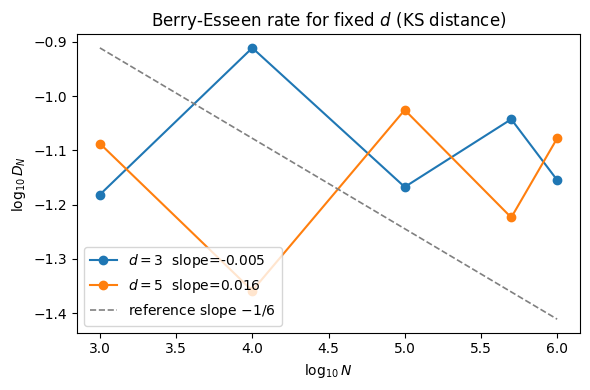

In [6]:


# Visualize the Berry-Esseen rate for fixed d (KS distance)
fig, ax = plt.subplots(figsize=(6, 4))

for d, sub in res_df.groupby("d"):
    sub = sub.sort_values("n")

    xs = np.log10(sub["n"].values)
    ys = np.log10(sub["D_n"].clip(lower=1e-12).values)  # avoid log10(0)

    # least‑squares slope on log‑log scale
    m, b = np.polyfit(xs, ys, 1)
    ax.plot(xs, ys, "o-", label=fr"$d={d}$  slope={m:.3f}")

# reference line with slope −1/6
N_min, N_max = res_df["n"].min(), res_df["n"].max()
ref_x = np.array([N_min, N_max])
y0 = np.log10(res_df["D_n"].max())          # anchor at left edge
ref_y = y0 - (1/6) * (np.log10(ref_x) - np.log10(N_min))
ax.plot(np.log10(ref_x), ref_y, "--", color="gray", lw=1.2,
        label=r"reference slope $-1/6$")

ax.set_xlabel(r"$\log_{10} N$")
ax.set_ylabel(r"$\log_{10} D_N$")
ax.set_title("Berry-Esseen rate for fixed $d$ (KS distance)")
ax.legend()
plt.tight_layout()
plt.show()

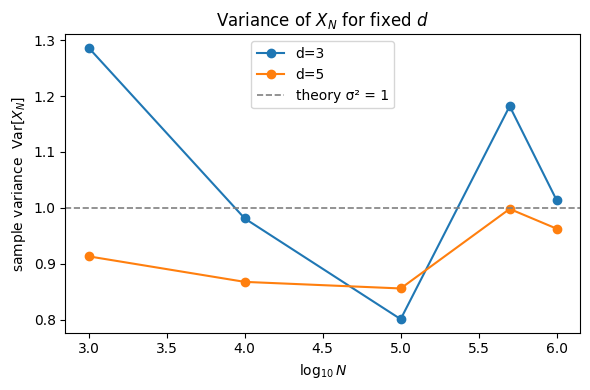

In [7]:
# Visualize the Variance
fig, ax = plt.subplots(figsize=(6, 4))

for d, sub in res_df.groupby("d"):
    sub = sub.sort_values("n")
    ax.plot(
        np.log10(sub["n"]),
        sub["var_n"],
        "o-",
        label=f"d={d}",
    )

ax.axhline(1.0, ls="--", color="gray", lw=1.2, label="theory σ² = 1")
ax.set_xlabel(r"$\log_{10} N$")
ax.set_ylabel(r"sample variance  $\operatorname{Var}[X_N]$")
ax.set_title("Variance of $X_N$ for fixed $d$")
ax.legend()
plt.tight_layout()
plt.show()

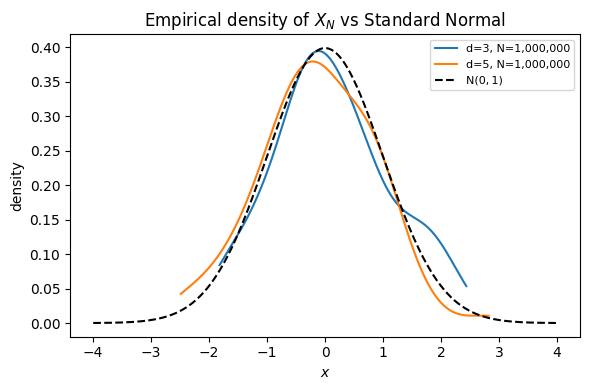

In [8]:
# Visualize the empirical density of X_N vs Standard Normal
fig, ax = plt.subplots(figsize=(6, 4))

for d in sorted(res_df["d"].unique()):
    row = res_df[res_df["d"] == d].sort_values("n").iloc[-1]  # largest N for this d
    ax.plot(
        row["kde_x"], row["kde_y"],
        label=f"d={d}, N={row['n']:,}"
    )

# standard normal pdf for reference
x_grid = np.linspace(-4, 4, 400)
ax.plot(x_grid, norm.pdf(x_grid), "k--", lw=1.5, label="N(0, 1)")

ax.set_xlabel(r"$x$")
ax.set_ylabel("density")
ax.set_title("Empirical density of $X_N$ vs Standard Normal")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Project 2 — Berry–Esseen Rate in the Sparse‑Growing‑Degree Regime

We now let the degree grow slowly with graph size,  
$$
d = d(N) \;\le\; N^{1/4},
$$
and test the refined prediction (Nagel 2025; Huang–Yau 2023) that the **rescaled KS error**

$$
\tilde D_N \;=\; \frac{D_N}{\sqrt{d}}
$$

still obeys the optimal rate  

$$
\tilde D_N \;=\; \Theta\!\bigl(N^{-1/6}\bigr).
$$

Equivalently,

$$
\sup_x \Bigl|\,\mathbb P\!\bigl(X_N \le x\bigr) - \Phi(x)\Bigr|
\;=\;
\Theta\!\bigl(\sqrt{d}\,N^{-1/6}\bigr),
\qquad
X_N \;=\; \sqrt{N}\,\langle q, u_2\rangle.
$$

---

## Experimental Design

| Stage | What we do | Key parameters |
|-------|------------|----------------|
| **Graph generation** | Build simple $d(N)$‑regular graphs using the same edge-swapping Monte Carlo method as Project 1. | $d \in \{3,5,8,10\}$ across $N \in \{1\,000, 10\,000, 50\,000\}$; analyze $(N,d)$ pairs satisfying $d \leq N^{0.25}$; ≈ 5k graphs per configuration. |
| **Backend optimization** | Leverage Rust backend for fast batch generation with adaptive batch sizes based on $N$. | Batch size: 512 for $N \leq 10k$, 256 for $N \leq 50k$, 64 for $N > 50k$ to manage memory. |
| **Storage format** | Same compressed sparse CSR format as Project 1 for consistent memory usage. | `scipy.sparse.save_npz` with uint8 adjacency data and int32/int64 indices based on $N$. |
| **Spectral step** | Form the normalised adjacency $\tilde A = A / \sqrt{d-1}$ and extract $u_2$. | Same `scipy.sparse.linalg.eigsh` configuration as Project 1. |
| **Statistic** | $X_N = \sqrt{N}\,\langle q, u_2\rangle$ with $q = e_1 - \tfrac1N\mathbf 1$ (normalised). | Same deterministic $q \perp \mathbf 1$ as in Project 1. |
| **Distance metric** | $\tilde D_N = D_N / \sqrt{d}$ where $D_N$ is the KS distance between $X_N$ and $\mathcal N(0,1)$. | `scipy.stats.kstest` with rescaling by $\sqrt{d}$ |
| **Rate extraction** | Regress $\log_{10}\tilde D_N$ on $\log_{10}N$. | Slope $\approx -1/6$ confirms universality after the $\sqrt{d}$ factor. |


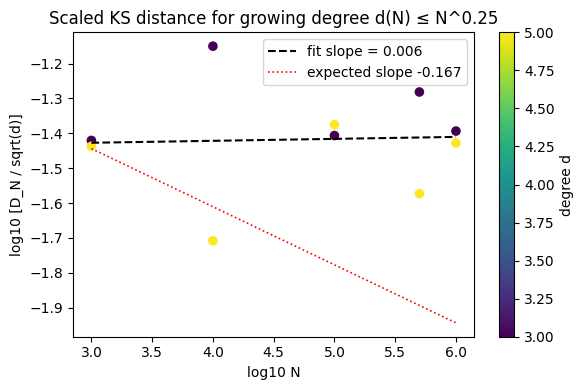

In [9]:
# Visualize the scaled KS distance for growing degree d(N) ≤ N^0.25
fig, ax = plt.subplots(figsize=(6, 4))

# points: all (n,d) pairs, colour‑by‑d for readability
scatter = ax.scatter(
    np.log10(limited_df["n"]),
    np.log10(limited_df["D_n"] / np.sqrt(limited_df["d"])),
    c=limited_df["d"], cmap="viridis", s=35
)

# global least‑squares slope in log–log space
xs = np.log10(limited_df["n"].values)
ys = np.log10(limited_df["D_n"].values / np.sqrt(limited_df["d"].values))
m, b = np.polyfit(xs, ys, 1)
ax.plot(xs, m * xs + b, "k--", lw=1.5, label=f"fit slope = {m:.3f}")

# reference – theoretical slope −1/6
N_min, N_max = limited_df["n"].min(), limited_df["n"].max()
ref_x = np.array([N_min, N_max])
ref_y = b - (1 / 6) * (np.log10(ref_x) - np.log10(N_min))
ax.plot(np.log10(ref_x), ref_y, "r:", lw=1.2, label=f"expected slope {(-1 / 6):.3f}")

ax.set_xlabel("log10 N")
ax.set_ylabel("log10 [D_N / sqrt(d)]")
ax.set_title("Scaled KS distance for growing degree d(N) ≤ N^0.25")
ax.legend()
cbar = plt.colorbar(scatter, ax=ax, label="degree d")
plt.tight_layout()
plt.show()

TypeError: expected non-empty vector for x

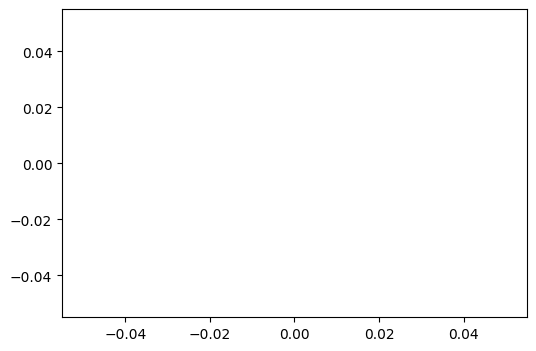

In [10]:
# See how this looks for points not covered by the bound d(N) ≤ N^0.25
# ── Points with d(N) > N^0.25  ──────────────────────────────────────────────
outside_df = full_df[full_df["d"] > full_df["n"] ** 0.25]

fig, ax = plt.subplots(figsize=(6, 4))

# scatter: log‑log of scaled KS distance, colour by degree
scatter = ax.scatter(
    np.log10(outside_df["n"]),
    np.log10(outside_df["D_n"] / np.sqrt(outside_df["d"])),
    c=outside_df["d"],
    cmap="plasma",
    s=35,
    marker="o",
    label="outside bound"
)

# least‑squares slope for these out‑of‑bound points
xs = np.log10(outside_df["n"].values)
ys = np.log10(outside_df["D_n"].values / np.sqrt(outside_df["d"].values))
m, b = np.polyfit(xs, ys, 1)
ax.plot(xs, m * xs + b, "k--", lw=1.5, label=f"fit slope = {m:.3f}")

# theoretical reference: slope −1/6 anchored at smallest N
N_min, N_max = outside_df["n"].min(), outside_df["n"].max()
ref_x = np.array([N_min, N_max])
ref_y = b - (1 / 6) * (np.log10(ref_x) - np.log10(N_min))
ax.plot(np.log10(ref_x), ref_y, "r:", lw=1.2, label="expected slope -1/6")

ax.set_xlabel("log10 N")
ax.set_ylabel("log10 [D_N / sqrt(d)]")
ax.set_title("Scaled KS distance for d(N) > N^0.25 (outside bound)")
ax.legend()
plt.colorbar(scatter, ax=ax, label="degree d")
plt.tight_layout()
plt.show()
